<a href="https://colab.research.google.com/github/Ash58/AishaSiddiqui/blob/master/mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# proposal https://www.overleaf.com/project/6063bbbfa08bd1005890d961

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

Downloading half of the correctly and incorrectly worn masks from MaskedFace-Net (10GB Each). This cell took me ~18 mins to run. if someone knows of a faster/more efficent way, please change my abomination

In [ ]:
download_link_correctly_worn = 'https://drive.google.com/file/d/17-FCstm8Fz3bDzFgTmOWHa_c39lTR_1P/view'
download_link_incorrectly_worn = 'https://drive.google.com/file/d/1gjltyD_MnNWcnd56NnjUOizdi39CUEPF/view'

# Downloading and unzipping correctly worn masks
!gdown --id 17-FCstm8Fz3bDzFgTmOWHa_c39lTR_1P
!mkdir correctly_worn
!unzip CMFD.zip -d ./correctly_worn

# Downloading and unzipping incorrectly worn masks
!gdown --id 1gjltyD_MnNWcnd56NnjUOizdi39CUEPF
!mkdir incorrectly_worn
!unzip IMFD.zip -d ./incorrectly_worn

Taking a look at some sample images 

In [ ]:
%matplotlib inline
import cv2
import os
import torch.utils.data as data
from torchvision import transforms
import _pickle as pickle
import torchvision.models as models
import glob

current_directory = os.getcwd()

def plot_image(im,title):
    plt.figure()
    plt.imshow(im[:,:,::-1])
    plt.title(title)

**Notes:**
- Each image is (1024,1024,3)
  - Maybe too large? need to resize?
- There are ~ 900 images in *correctly_worn/00000*  and ~ 900 images in *incorrectly_worn/00000*
  - Might be more than enough images, the other 30k images are unessesary 
- There is a distinction between uncovered nose and uncovered mouth, maybe useful later?

(1024, 1024, 3)
(1024, 1024, 3)


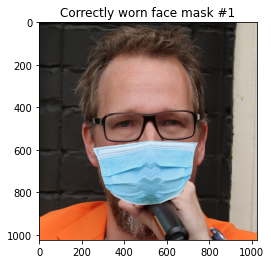

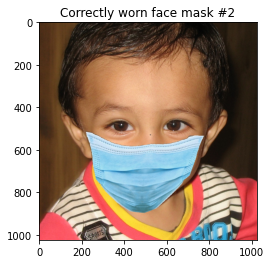

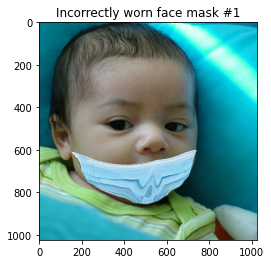

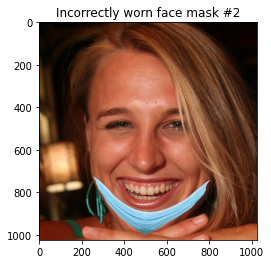

In [ ]:
correct_sample1 = cv2.imread('correctly_worn/00000/00005_Mask.jpg')
correct_sample2 = cv2.imread('correctly_worn/00000/00010_Mask.jpg')
incorrect_sample1 = cv2.imread('incorrectly_worn/00000/00000_Mask_Mouth_Chin.jpg')
incorrect_sample2 = cv2.imread('incorrectly_worn/00000/00001_Mask_Chin.jpg')

print(correct_sample1.shape)
print(incorrect_sample1.shape)
plot_image(correct_sample1, 'Correctly worn face mask #1')
plot_image(correct_sample2, 'Correctly worn face mask #2')
plot_image(incorrect_sample1, 'Incorrectly worn face mask #1')
plot_image(incorrect_sample2, 'Incorrectly worn face mask #2')

In [ ]:
import os
import pandas as pd
unique_types = pd.Series([i[6:] for i in os.listdir('incorrectly_worn/00000/')])
unique_types.unique()

array(['Mask_Chin.jpg', 'Mask_Mouth_Chin.jpg', 'Mask_Nose_Mouth.jpg'],
      dtype=object)

DataLoaders

In [ ]:
# we can init a small amount of data for now to test the model
# starting off with 400 images (200 correctly worn & 200 incorrectly worn)
# format of getting an element : {'image': image, 'label': label}

# we should probably shuffle the images
class MaskedDataset(data.Dataset):
    def __init__(self, transformation, mode ='train'):

      self.mode = mode
      self.transformation = transformation

      if mode == 'train':
        self.images = [('correctly_worn/00000/' + file_name,1) for file_name in os.listdir('correctly_worn/00000/')[:200]]
        self.images += [('incorrectly_worn/00000/' + file_name,0) for file_name in os.listdir('incorrectly_worn/00000/')[:200]]
      if mode == 'val':
        self.images = [('correctly_worn/01000/' +file_name,1) for file_name in os.listdir('correctly_worn/01000/')[:200]]
        self.images += [('incorrectly_worn/01000/' +file_name,0) for file_name in os.listdir('incorrectly_worn/01000/')[:200]]
      

    def __len__(self):
      return  len(self.images)

    def __getitem__(self, index):
      img = Image.open(self.images[index][0]).convert('RGB')
      label = self.images[index][1]

      tensor_img = self.transformation(img)
      return {'image' : tensor_img, 'label': label}





Model Architecture

**Note:** The inputs are (3,256,256)  tensors


In [ ]:
# trying out a YOLO architecture
# test data only provides 0/1 output incorrectly worn/correctly worn
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        

    def forward(self, x):

        

SyntaxError: ignored

hyperparameters

In [ ]:
batch_size = 16
learning_rate = 0.002
epochs = 100

dataloaders

In [ ]:
transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = MaskedDataset(transform,'train') 
val_set = MaskedDataset(transform,'val') 

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [ ]:
for idx, batch in enumerate(train_dataloader):
    index, labels = batch
    print(labels[0])

    break

l


optimizer, loss function, scheduler, etc

In [ ]:
model = Net()
optim = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay= .1, momentum = .01)  
loss_function = nn.BCELoss() 
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_dataloader), epochs=epochs)

training/validation loop

In [ ]:
train_losses = []
val_losses = []
for epoch in range(epochs):

    #Training phase
    model.train()  #Setting the model to train phase
    train_loss = []
    val_loss = []
    train_acc = 0.
    val_acc = 0.
    
    for idx, batch in enumerate(train_dataloader):
      
      images = batch['image']
      labels = batch['label']

      ##forward pass
      result = model(images)

      ##loss
      loss = loss_function(result,labels) #may need to resize labels, depending on our implementation

      ## backward prop
      optim.zero_grad()
      loss.backward()

      ##step optimizer
      optim.step()
      scheduler.step() # may not be necessesary, depending on our implementation
      

      ## TODO: compute accuracy and track accuracy and loss
      


    #Validation phase
    model.eval() 
    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad(): 
          images = batch['image']
          labels = batch['label']
          result = model(images)

          ## TODO: compute accuracy and track accuracy and loss


    if epoch%100==0:
      train_losses.append(np.mean(train_loss))
      val_losses.append(np.mean(val_loss))
      print("Epoch : {}, Train loss: {} , Train Acc: {}, Val loss: {}, Val acc: {}".format(epoch, np.mean(train_loss), train_acc, np.mean(val_loss), val_acc))

Plots, results, discussion, etc

In [ ]:
#

Metrics - avg precision, IOU